#### Import libraries

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

### Transformation of images

Augmentation, normalization and transformation for train data:

In [3]:
data_transforms = transforms.Compose([
    # Augmentation
    transforms.RandomHorizontalFlip(p=0.3),  
    transforms.RandomRotation(15), 
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1), 
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.1),
    #  transformation
    transforms.ToTensor(),
    # normalization
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

Transformation and normalization for test/split data:

In [4]:
test_val_transforms = transforms.Compose([
    #  transformation
    transforms.ToTensor(),
    # normalization
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

Read images from folders and put them in dataset:

In [5]:
train_dataset = datasets.ImageFolder(root='data/split_dataset/train', transform=data_transforms)
val_dataset = datasets.ImageFolder(root='data/split_dataset/val', transform=test_val_transforms)
test_dataset = datasets.ImageFolder(root='data/split_dataset/test', transform=test_val_transforms)

### Check images 

#### 1) Number of images

In [6]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 4803
    Root location: data/split_dataset/train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.3)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
               RandomApply(
               p=0.1
               GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0))
           )
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [7]:
print(f"Number of images in the training dataset: {len(train_dataset)}")
print(f"Number of images in the training dataset: {len(val_dataset)}")
print(f"Number of images in the training dataset: {len(test_dataset)}")

Number of images in the training dataset: 4803
Number of images in the training dataset: 1029
Number of images in the training dataset: 1030


The number is the same as in "data-preparation-1"

#### 2) Image transformation

lets plot some train image examples:

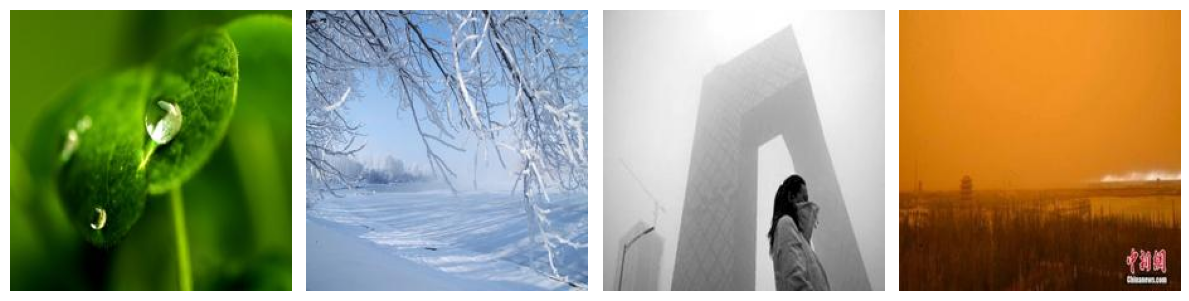

In [8]:
image_paths = [
    "data//split_dataset//train//dew//2208.jpg",   
    "data//split_dataset//train//rime//4931.jpg", 
    "data//split_dataset//train//fogsmog//4075.jpg",
    "data//split_dataset//train//sandstorm//2910.jpg"  
]
plt.figure(figsize=(12, 5))
for i, image_path in enumerate(image_paths):
    img = Image.open(image_path)
    img_size = img.size  
    
    plt.subplot(1, 4, i+1)  
    plt.imshow(img)
    plt.axis('off')  

plt.tight_layout()
plt.show()

Function to get image from tensor form:

In [9]:
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  
    return tensor

Plot images after transformation:

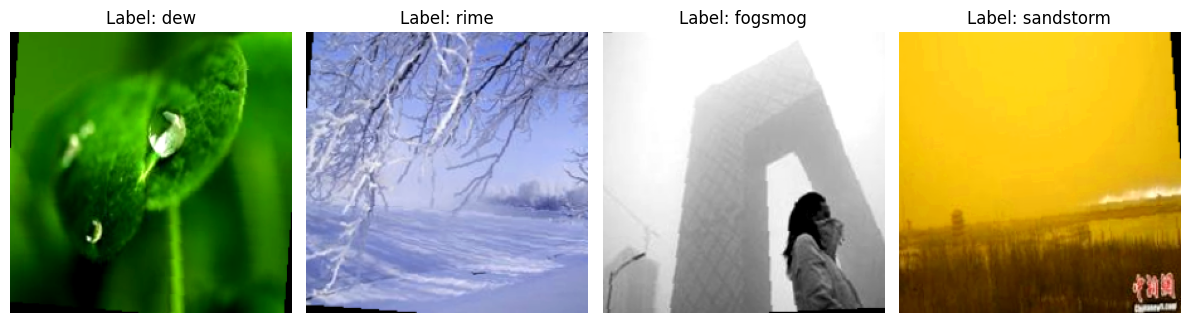

In [10]:
indexes = [0, 3072, 489, 3884]

fig, axes = plt.subplots(1, 4, figsize=(12, 5))

for idx, ax in zip(indexes, axes):
    image, label = train_dataset[idx] 
    image = denormalize(image, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
    npimg = image.numpy().transpose((1, 2, 0)) 
    
    ax.imshow(npimg)
    ax.set_title(f"Label: {train_dataset.classes[label]}")
    ax.axis('off')  

plt.tight_layout()
plt.show()

#### 3) Data loader

In [11]:
batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
train_loader

### CNN

Here I define my CNN model: 

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First convolutional layer: 3 input channel (RGB), 32 output channels
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1) 
        # Second convolutional layer: 32 input channel, 64 output channels
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) 
        # Max pooling layer: 2x2 window, stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 56 * 56, 128) 
        
        # len(train_dataset.classes) = 11
        self.fc2 = nn.Linear(128, len(train_dataset.classes))  

    def forward(self, x):
        # conv1 + relu + pooling
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        # conv2 + relu + pooling
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        # Flatten the tensor
        x = x.reshape(x.shape[0], -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

Loss fucntion:

In [ ]:
criterion = nn.CrossEntropyLoss()

Optimizer:

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)